# HIF Case Study

This notebook is used to replcate the use case experiment in the paper **[HIF: The hypergraph interchange format for higher-order networks](https://arxiv.org/pdf/2507.11520)** that demonstrates the use of the hypergraph interchange formation (HIF).

The following hypergraph libraries have the HIF loading and saving functions allowing for the analysis of the same hypergraph over each library:
* HyperNetX (HNX)
* HyperGraphX (HGX)
* SimpleHypergraphs
* TopoNetX
* Hypergraph Analysis Toolbox (HAT)
* compleX Group Interactions (XGI)

## Publications Case Study Dataset

The **Publications Case Study Dataset** is a collection of publication records for higher-order network analysis. It's a filtered subset of a larger bibliographic database that was originally stored as a JSON file. The data was curated to include only publications with the keyword "**Hypergraph**." This dataset is derived from the following sources:

* arXiv
* bioRxiv
* the dblp computer science bibliography
* the U.S. Office of Scientific and Technical Information (OSTI)

This focused approach results in a dataset that is both attribute-rich and of a manageable size for analysis.

## Hypergraph Structure and Attributes

A hypergraph was extracted from the initial JSON data by treating each publication as a **hyperedge** and each author as a **node**. The process involved parsing the JSON file, iterating through each publication record, and identifying the authors associated with that publication. The extraction followed these steps:

1.  **Node Identification:** Each unique author found in the publication records became a node in the hypergraph.
2.  **Hyperedge Creation:** Each publication, with its corresponding list of authors, was treated as a single hyperedge. This allows for the representation of a multi-way interaction where all co-authors are linked by a single publication.
3.  **Attribute Assignment:** The metadata for each publication, such as funding agencies, publication dates, and keywords, was assigned as attributes to the corresponding hyperedge. Similarly, institution attributes were assigned to the author nodes.

The hyperedges (publications) include the following specific metadata:

* **Funding agencies:** The funding sources for the publication.
* **Abstracts:** A summary of the publication's content.
* **Publication dates:** The date the publication was released.
* **Keyword tags:** A list of keywords associated with the publication.
* **Source venues:** The journal or conference where the publication was published.

The nodes (authors) have associated **institution attributes**. It is important to note that there are **no incidence attributes** in this dataset. This means that a node's (author's) property does not change depending on the specific hyperedge (publication) it is associated with.

In [24]:
# import standard packages for analysis and plotting
import json

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def set_fonts(extra_params={}):
    params = {
        "font.family": "Serif",
        # "font.sans-serif": ["Tahoma", "DejaVu Sans", "Lucida Grande", "Verdana"],
        "mathtext.fontset": "cm",
        "legend.fontsize": 14,
        "axes.labelsize": 14,
        "axes.titlesize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "figure.titlesize": 14,
    }
    for key, value in extra_params.items():
        params[key] = value
    pylab.rcParams.update(params)


set_fonts()

In [25]:
file_path = "data/publications.hif.json"
with open(file_path, "r") as f:
    HIF_publications = json.load(f)

## HAT: Hypergraph Analysis Toolbox

In [26]:
from HAT import Hypergraph as HatHypergraph
from HAT import draw as HATdraw
from HAT.metrics import nonlinear_eigenvector_centrality

# Construct hypergraph from hif data
H_hat = HatHypergraph.from_hif(HIF_publications)

# Compute connected components into nodes dataframe
cc = H_hat.connected_components
print(cc.head())

# Get the most frequent connected component ID
most_common_component = H_hat.nodes["connected components"].mode().iloc[0]

# Select nodes belonging to the most common (largest) connected component
largest_cc = [
    node
    for node in range(H_hat.nodes.shape[0])
    if H_hat.nodes["connected components"].iloc[node] == most_common_component
]
print(f"{len(largest_cc)=}")

# Reduce the hypergraph to largest connected component
reduced_matrix = H_hat.incidence_matrix[largest_cc, :]
nonzero_columns = ~np.all(reduced_matrix == 0, axis=0)
reduced_incidence_matrix = reduced_matrix[:, nonzero_columns]

H_hat_cc = HatHypergraph(
    incidence_matrix=reduced_incidence_matrix, nodes=H_hat.nodes.iloc[largest_cc]
)
print(f"{H_hat_cc.nodes.shape=}")
print(f"{H_hat_cc.edges.shape=}")

# Compute node and edge centrality
node_centrality, edge_centrality = nonlinear_eigenvector_centrality(
    H_hat_cc, model="Linear"
)

             Nodes  connected components
0  Daniel T. Chang                     0
1     Mirjam Trieb                     1
2     Moritz Weber                     1
3      Dean Zenner                     1
4   R. Vishnupriya                     2
len(largest_cc)=108
H_hat_cc.nodes.shape=(108, 4)
H_hat_cc.edges.shape=(30, 2)


Iterations:   2%|▏         | 52/3000 [00:00<00:00, 17315.32it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/xgi/lib/python3.13/site-packages/HAT/metrics.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HG.nodes['NLEC'] = vertex_centrality


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(5.5, 4))
gs = GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[1, 3], figure=fig)

# (1) Incidence matrix plot (top-right): largest
ax_matrix = fig.add_subplot(gs[0, 1])
plt.sca(ax_matrix)
HATdraw.incidence_plot(H_hat_cc, shade_rows=False)
ax_matrix.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax_matrix.set_title("Incidence Matrix")

# (2) Edge centrality: vertical bar plot from the top (bottom-right)
ax_edge = fig.add_subplot(gs[1, 1])
sns.barplot(edge_centrality, ax=ax_edge, color="k")
ax_edge.invert_yaxis()  # start from top
ax_edge.set_xlabel("Hyperedges")
ax_edge.set_ylabel("Centrality")
ax_edge.set_xticks([])
ax_edge.set_yticks([])

# (3) Node centrality: horizontal bar plot from the right (top-left)
ax_node = fig.add_subplot(gs[0, 0])
sns.barplot(node_centrality[::-1], ax=ax_node, orient="h", color="k")
ax_node.invert_xaxis()  # right-aligned
ax_node.set_xlabel("Centrality")
ax_node.set_ylabel("Nodes")
ax_node.set_xticks([])
ax_node.set_yticks([])
ax_node.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# (4) Turn off bottom-left subplot
fig.add_subplot(gs[1, 0]).axis("off")

plt.tight_layout()
plt.savefig("../figures/hat_incidence_matrix.svg", dpi=300, bbox_inches="tight")

## Hypergraphx

In [28]:
import hypergraphx
from hypergraphx.readwrite import read_hif

H = read_hif("data/publications.hif.json")
lg = H.subhypergraph_largest_component()

No hypergraph type - assume undirected


In [29]:
from hypergraphx.communities.hy_mmsbm.model import HyMMSBM
from hypergraphx.communities.hy_sc.model import HySC
from hypergraphx.communities.hypergraph_mt.model import HypergraphMT
from hypergraphx.core.hypergraph import Hypergraph
from hypergraphx.readwrite.load import load_hypergraph
from hypergraphx.utils import calculate_permutation_matrix, normalize_array
from hypergraphx.viz import draw_communities

max_iter = 200  # maximum number of EM iteration steps before aborting
check_convergence_every = 10  # number of steps in between every convergence check
normalizeU = False  # if True, then the membership matrix u is normalized such that every row sums to 1
baseline_r0 = False  # if True, then for the first iteration u is initialized around the solution of the Hypergraph Spectral Clustering
verbose = False  # flag to print details

K = 5  # number of communities
seed = 20  # random seed
n_realizations = 5  # number of realizations with different random initialization

model = HypergraphMT(
    n_realizations=n_realizations,
    max_iter=max_iter,
    check_convergence_every=check_convergence_every,
    verbose=verbose,
)
u_HypergraphMT, w_HypergraphMT, _ = model.fit(
    lg, K=K, seed=seed, normalizeU=normalizeU, baseline_r0=baseline_r0
)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

cmap = sns.color_palette("Paired", desat=0.7)
col = {k: matplotlib.colors.to_hex(cmap[k * 2], keep_alpha=False) for k in np.arange(K)}
fig, ax = plt.subplots(figsize=(3.5, 4))
draw_communities(
    hypergraph=lg,
    u=u_HypergraphMT,
    figsize=(10, 10),
    col=col,
    ax=ax,
    with_node_labels=False,
    node_size=0.05,
)
plt.savefig("../figures/hgx_communities.svg", dpi=300, bbox_inches="tight")

setting certain d in w to zero: [0 8]
setting certain d in w to zero: [0 8]
setting certain d in w to zero: [0 8]
setting certain d in w to zero: [0 8]
setting certain d in w to zero: [0 8]


In [37]:
from hypergraphx.motifs import compute_motifs
from hypergraphx.viz.draw_motifs import draw_motifs

m = compute_motifs(H, order=3, runs_config_model=0)

hypergraphs = []
for motif in m["observed"]:
    if motif[1] > 0 or motif[1] < 0:
        hypergraphs.append(motif)
# sort in descending order
hypergraphs.sort(key=lambda x: x[1], reverse=True)
hypergraphs = [h[0] for h in hypergraphs[:3]]

draw_motifs(hypergraphs, node_size=900, save_path="../figures/hgx_motifs3.svg")

Computing observed motifs of order 3...


In [38]:
m = compute_motifs(H, order=4, runs_config_model=0)

hypergraphs = []
for motif in m["observed"]:
    if motif[1] > 0 or motif[1] < 0:
        hypergraphs.append(motif)
# sort in descending order
hypergraphs.sort(key=lambda x: x[1], reverse=True)
hypergraphs = [h[0] for h in hypergraphs[:3]]
draw_motifs(hypergraphs, node_size=900, save_path="../figures/hgx_motifs4.svg")

Computing observed motifs of order 4...


## HyperNetX

Here we demo loading in the hypergraph using HNX and demoing the unique homology capabilities of the library.

In [9]:
import hypernetx as hnx

In [10]:
H_hnx = hnx.from_hif(HIF_publications)

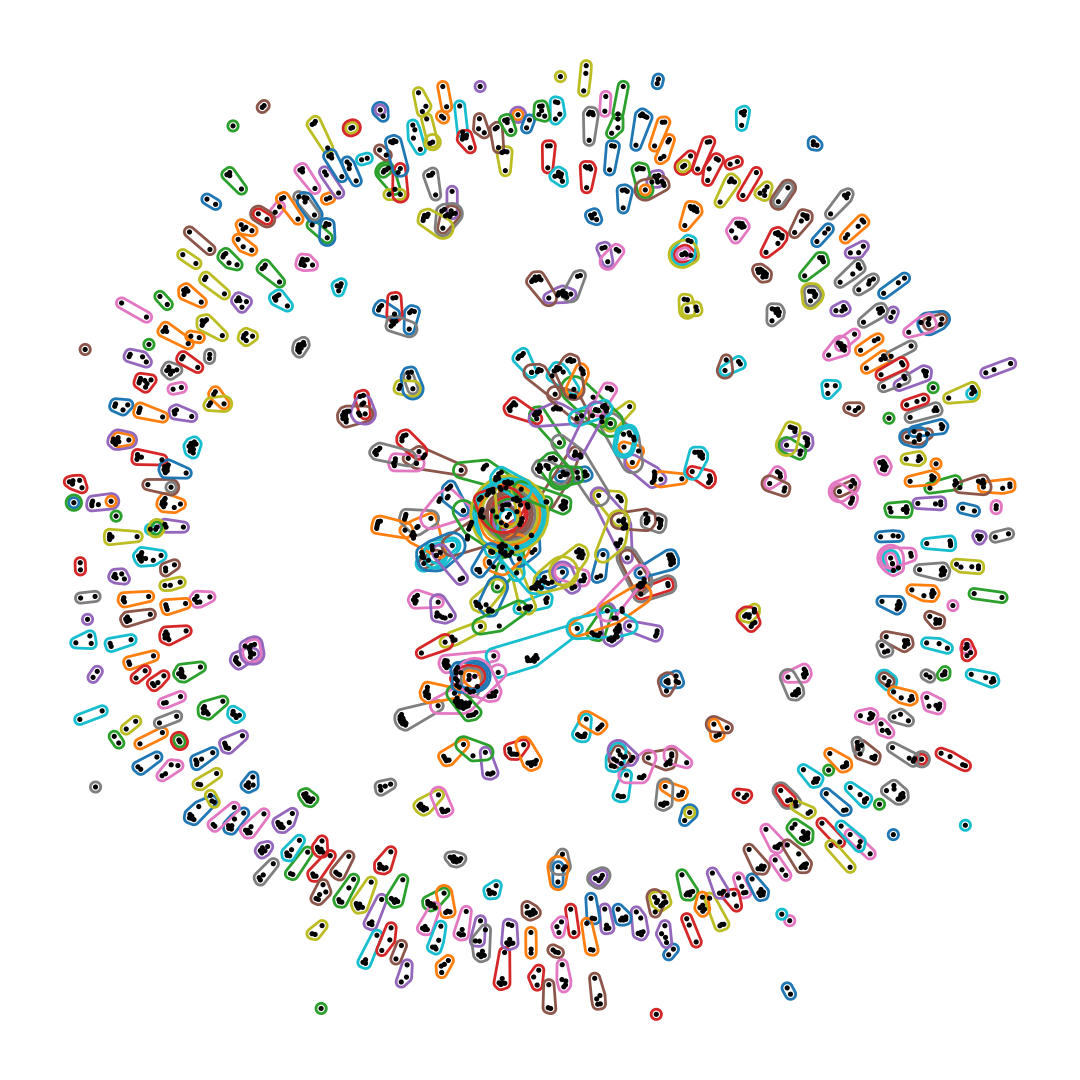

In [11]:
plt.figure(figsize=(5.5, 5.5))
hnx.draw(
    H_hnx,
    with_edge_labels=False,
    with_node_labels=False,
    node_radius=0.2,
    edges_kwargs={"lw": 0.5},
)
plt.tight_layout()
plt.savefig("../figures/full_publications.pdf", dpi=1000)

In [12]:
# Getting the main connected component of hypergraph
import numpy as np

Hs = list(H_hnx.s_component_subgraphs(s=1, return_singletons=False))
I = np.argsort([len(H_CC.incidences.dataframe) for H_CC in Hs])
Hs = [Hs[i] for i in I]
H = Hs[-1]

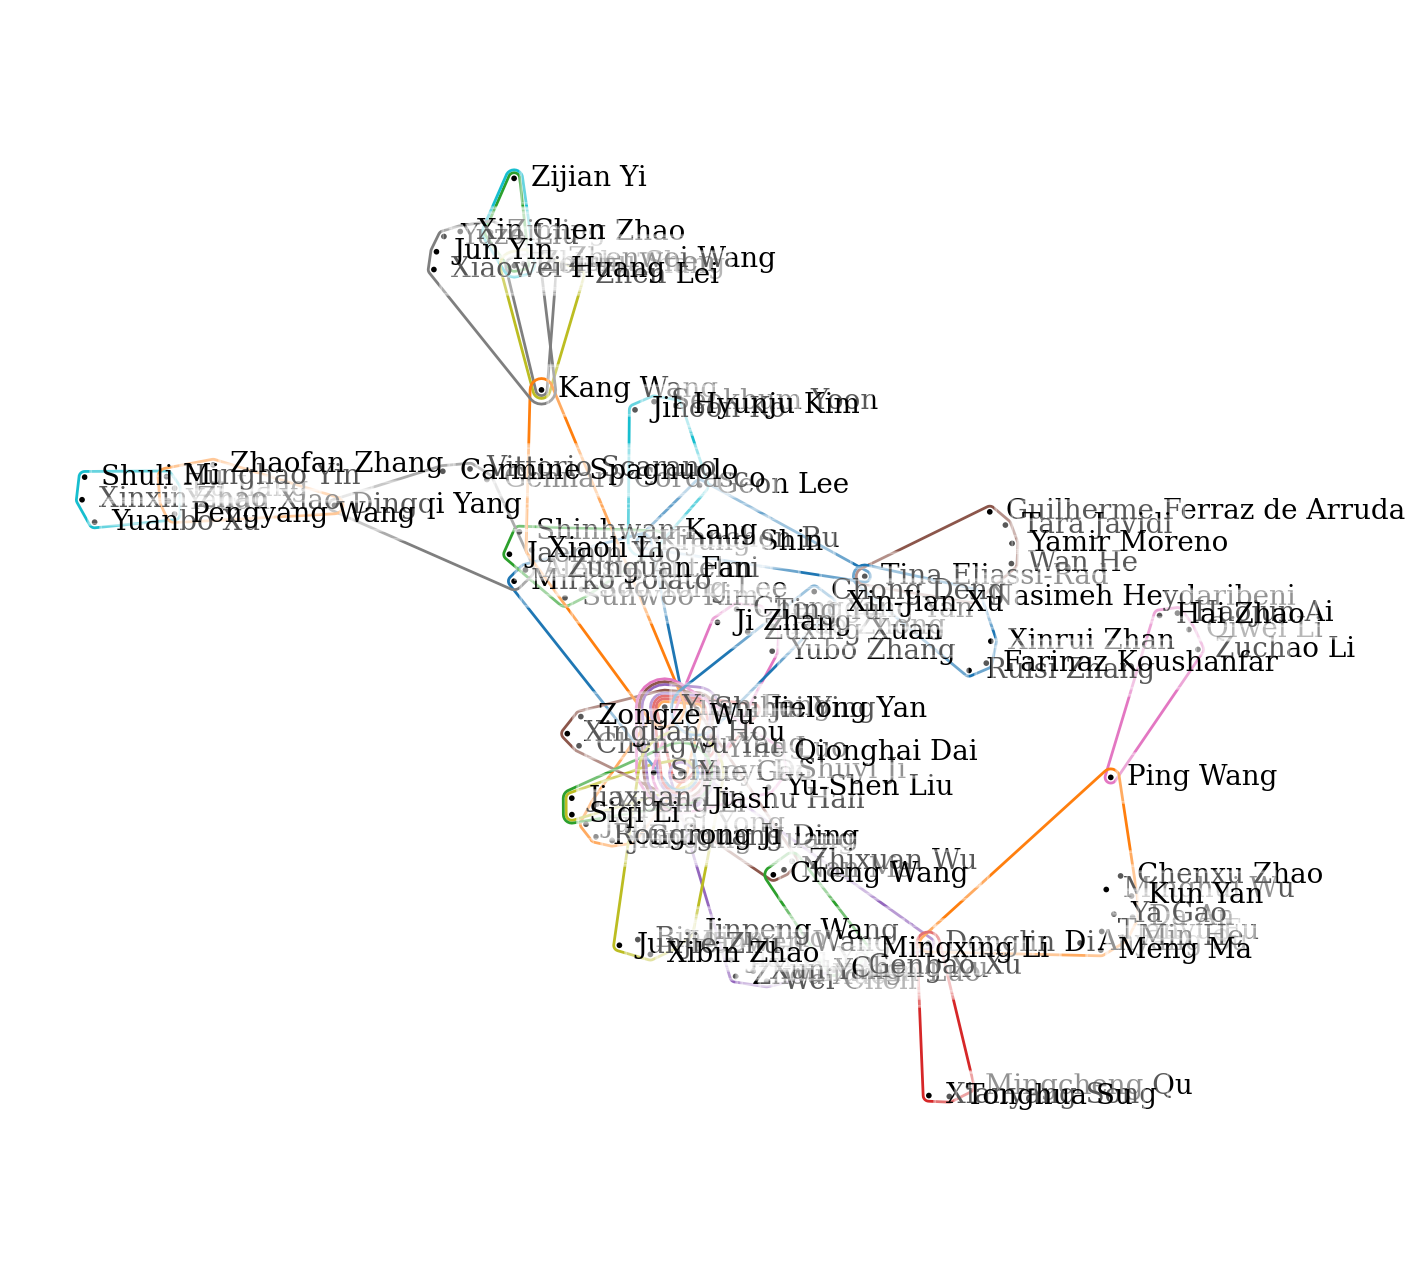

In [13]:
pos = hnx.draw(
    H,
    with_edge_labels=False,
    with_node_labels=True,
    node_radius=0.2,
    edges_kwargs={"lw": 0.5},
    return_pos=True,
)
plt.show()

## One-Dimensional Homology of a Hypergraph Using HNX

/var/folders/12/5tnqqv2d58qb9hs_fcf9tcdh0000gp/T/ipykernel_8564/394069652.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


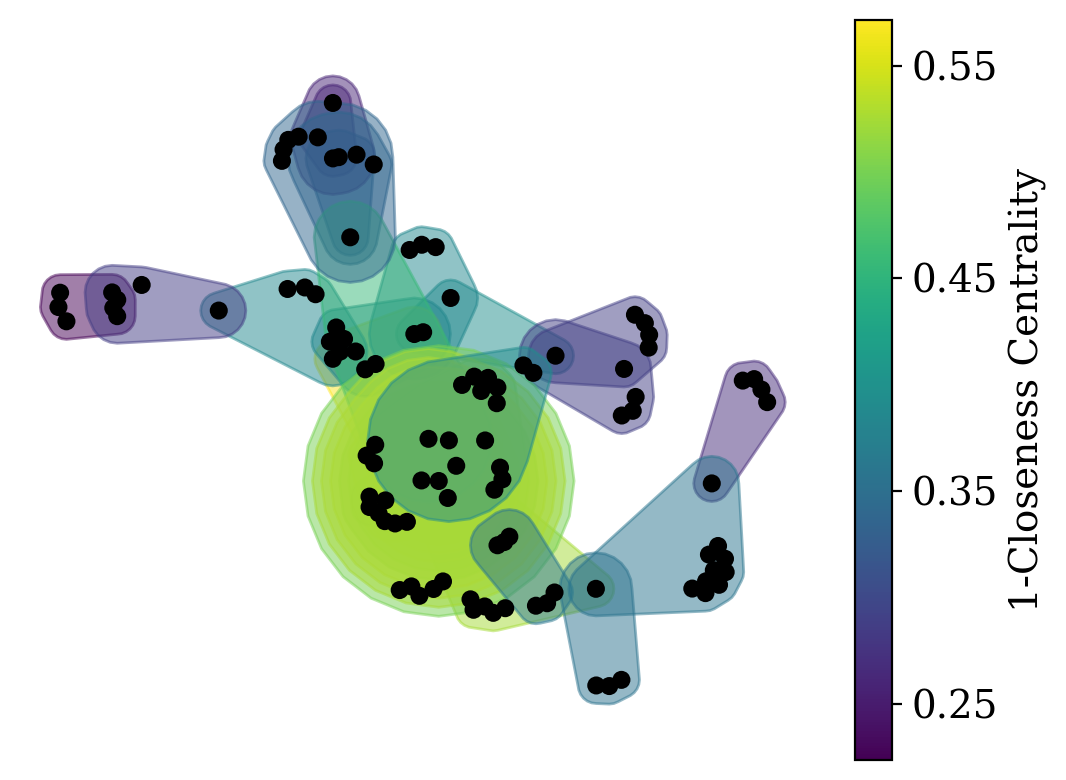

In [14]:
import hypernetx as hnx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Assuming your hypergraph 'H' is already defined
s = 1
edge_centrality = hnx.s_closeness_centrality(H, s=s)

# Get the centrality values and the edges
edges = list(H.edges)
centrality_values = np.array([edge_centrality[e] for e in edges])

# Normalize the centrality values to the range [0, 1]
if centrality_values.size > 0:
    normalized_centrality = (centrality_values - np.min(centrality_values)) / (
        np.max(centrality_values) - np.min(centrality_values)
    )
else:
    normalized_centrality = np.array([])  # Handle the case of no edges

# Choose a colormap
cmap = cm.get_cmap("viridis")

# Map the normalized centrality values to colors
edge_colors = cmap(normalized_centrality)

# Create a dictionary to pass to edges_kwargs for coloring
edge_style = {}
for i, edge in enumerate(edges):
    if i < len(edge_colors):
        edge_style[edge] = edge_colors[i]

# Create the hypergraph plot
fig, ax = plt.subplots(figsize=(5.5, 4))
hnx.draw(
    H,
    pos=pos,
    with_edge_labels=False,
    with_node_labels=False,
    node_radius=1,
    edges_kwargs={"color": list(edge_style.values()), "lw": 2, "alpha": 0.5},
    ax=ax,
)

# Add the colorbar
sm = cm.ScalarMappable(
    cmap=cmap,
    norm=plt.Normalize(vmin=np.min(centrality_values), vmax=np.max(centrality_values)),
)
sm.set_array([])  # For older versions of matplotlib
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(f"{s}-Closeness Centrality", fontsize=14)
cbar.set_ticks([0.25, 0.35, 0.45, 0.55])
plt.tight_layout()
plt.savefig("../figures/hnx.svg", dpi=1000)
plt.show()

In [15]:
s = 1
print(f"The {s}-closeness centrality of the edges in hypergraph H is:")
print("-" * 100)

d = hnx.s_closeness_centrality(H, s=s)
for e in H.edges:
    print(f"{e}: {d[e]}")

The 1-closeness centrality of the edges in hypergraph H is:
----------------------------------------------------------------------------------------------------
A Survey on Hypergraph Mining: Patterns, Tools, and Generators: 0.3950617283950617
Hyper-YOLO: When Visual Object Detection Meets Hypergraph Computation: 0.5614035087719298
HyperSMOTE: A Hypergraph-based Oversampling Approach for Imbalanced Node Classifications: 0.2601626016260163
LightHGNN: Distilling Hypergraph Neural Networks into MLPs for $100\times$ Faster Inference: 0.5614035087719298
Hyper-3DG: Text-to-3D Gaussian Generation via Hypergraph: 0.5245901639344263
Assigning Entities to Teams as a Hypergraph Discovery Problem: 0.2882882882882883
Hypergraph based Understanding for Document Semantic Entity Recognition: 0.26666666666666666
Towards Multi-agent Policy-based Directed Hypergraph Learning for Traffic Signal Control: 0.3368421052631579
Hypergraph-based Multi-View Action Recognition using Event Cameras: 0.5
Multimodal F

In [16]:
import julia
from julia.api import Julia

# julia.install()
jl = Julia(compiled_modules=False)

%load_ext julia.magic

/opt/homebrew/Caskroom/miniforge/base/envs/xgi/lib/python3.13/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.11.7+0.aarch64.apple.darwin14. You currently have `1.11.5+0.aarch64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.7+0.aarch64.apple.darwin14 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


Initializing Julia interpreter. This may take some time...


In [17]:
%%julia
using Pkg
Pkg.add(url="https://github.com/AleksanderWWW/SimpleHypergraphs.jl.git", rev="aw/hif-import-export", io=devnull)
Pkg.add("Test", io=devnull)
Pkg.add("StatsBase", io=devnull)
Pkg.add("Random", io=devnull)
Pkg.add("DataStructures", io=devnull)
Pkg.add("Graphs", io=devnull)
Pkg.add("GraphPlot", io=devnull)
Pkg.add("Colors", io=devnull)
Pkg.add("ColorSchemes", io=devnull)
Pkg.add("Compose", io=devnull)
using Test, SimpleHypergraphs, StatsBase
using Random
using DataStructures
using Graphs
using GraphPlot
using Colors, ColorSchemes

In [18]:
%%julia
file_path = "data/publications.hif.json" # Your specified file path
hg = hg_load(file_path, HIF_Format(), T=Bool)

cmpts = get_connected_components(hg)
n, id = findmax(length, cmpts)

to_select = Set(cmpts[id])


for v in nhv(hg):-1:1
    if !(v in to_select)
        remove_vertex!(hg, v)
    end
end

SimpleHypergraphs.prune_hypergraph(hg)

cnm = CFModularityCNMLike(5000)
Random.seed!(1234)
cnm_comms = findcommunities(hg, cnm)

println("We found $(length(cnm_comms.bp)) communities ")

t = Graphs.Graph(get_twosection_adjacency_mx(hg;replace_weights=1))

my_colors = vcat(ColorSchemes.rainbow[range(1, stop=length(ColorSchemes.rainbow), step=3)], ColorSchemes.rainbow[2]);
function get_color(i, comms, colors)
    for j in 1:length(comms)
        if length(comms[j]) > 1 && i in comms[j]
            return "#"*hex(colors[j % length(colors) + 1])
        end
    end
    return "#000000"
end;

degrees = Graphs.degree.(Ref(t), Graphs.vertices(t));
dsize = 5 .+ 1.5 .* degrees./maximum(degrees);

saveplot(
    gplot(
        t,
        nodesize = dsize,
        nodefillc=get_color.(1:Graphs.nv(t), Ref(cnm_comms.bp), Ref(reverse(my_colors))),
        plot_size = (5cm, 5cm)
    ),
    "../figures/simplehypergraphs.svg"
)

┌ Warning: Edges in the source file were not sorted - their order was changed.
└ @ SimpleHypergraphs ~/.julia/packages/SimpleHypergraphs/hundc/src/io_hif.jl:45
┌ Warning: Nodes in the source file were not sorted - their order was changed
└ @ SimpleHypergraphs ~/.julia/packages/SimpleHypergraphs/hundc/src/io_hif.jl:49


We found 16 communities 


# XGI

In [19]:
import xgi

In [20]:
H_xgi = xgi.read_hif(file_path)
testH = H_xgi.cleanup(in_place=False)

/opt/homebrew/Caskroom/miniforge/base/envs/xgi/lib/python3.13/copy.py:88: DeprecationWarning: Pickle, copy, and deepcopy support will be removed from itertools in Python 3.14.
  rv = reductor(4)


In [21]:
fig = plt.figure(figsize=(3.5, 4))

xgi.draw(
    testH,
    pos=xgi.pca_transform(xgi.pairwise_spring_layout(testH, seed=0), theta=30),
    hull=True,
    node_size=testH.nodes.degree,
    node_fc=testH.nodes.clique_eigenvector_centrality,
)
plt.tight_layout()
plt.savefig("../figures/xgi_network.svg", dpi=1000)

fig = plt.figure(figsize=(3.5, 4))
plt.subplot(211)
y1 = testH.nodes.degree.asnumpy()
y2 = testH.nodes.average_neighbor_degree.asnumpy()
idx = np.argsort(y1)[::-1]
plt.plot(y1[idx], "-", color="maroon")
plt.plot(y2[idx], "--", color="teal")
plt.xticks([], [])
plt.ylabel("Deg.", labelpad=12)
plt.yscale("log")

plt.subplot(212)
y1 = testH.nodes.clique_eigenvector_centrality.asnumpy()
y2 = testH.nodes.h_eigenvector_centrality.asnumpy()
idx = np.argsort(y1)[::-1]
plt.plot(y1[idx], "-", color="maroon")
plt.plot(y2[idx], "--", color="teal")
plt.xlabel("Node", labelpad=10)
plt.ylabel("Cent.")
plt.yscale("log")
sns.despine()
plt.tight_layout()
plt.savefig("../figures/xgi.svg", dpi=1000)

/opt/homebrew/Caskroom/miniforge/base/envs/xgi/lib/python3.13/copy.py:88: DeprecationWarning: Pickle, copy, and deepcopy support will be removed from itertools in Python 3.14.
  rv = reductor(4)
/Users/yyu8dx/Documents/GitHub/xgi/xgi/algorithms/centrality.py:372: UserWarning: Iteration did not converge!
  warn("Iteration did not converge!")


In [22]:
plt.close("all")